In [ ]:
from custom_models.cnn import CNN
from helper_methods import get_data_loaders
from pipeline import CustomModelPipeline
from torch import optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import torch
import pandas as pd
from vit_pytorch import ViT


# set seaborn style
sns.set_theme(
    context="notebook", style="whitegrid", palette="bright", color_codes=True, rc=None
)

In [ ]:
# Experiment repetitions
N_REPEATS = 5

# Training config
N_EPOCHS = 50
DATA_AUG_TRAIN = True

#Model Hyperparameters
LOSS_FN = nn.CrossEntropyLoss()
OPTIMIZER_CLASS = optim.Adam
LR = 0.001

# Early Stopping Configuration
ES_PATIENCE = 10
MIN_ES_DELTA = 0.001

In [ ]:

def init_pipeline(
    train_loader,
    validation_loader,
    train_loader_at_eval,
    test_loader,
    input_size,
    num_classes,
    patience=ES_PATIENCE,  # Add patience parameter
):

    model = ViT(
        image_size=28,  # DermaMNIST images are 28×28
        patch_size=4,  # Smaller patch size works well for MNIST-type datasets
        num_classes=7,  # DermaMNIST has 7 classes
        dim=128,  # Smaller embedding dimension
        depth=8,  # Fewer transformer layers
        heads=8,  # Fewer attention heads
        mlp_dim=1024,  # Smaller MLP dimension
        dropout=0.2,
        emb_dropout=0,
    )

    pipeline = CustomModelPipeline(
        model=model,
        criterion=LOSS_FN,
        min_delta=MIN_ES_DELTA,
        optimizer_class=OPTIMIZER_CLASS,
        optimizer_params={
            "lr": LR,
        },
        n_epochs=N_EPOCHS,
        training_data=train_loader,
        validation_data=validation_loader,
        test_data=test_loader,
        patience=patience,  # Pass patience parameter
        device="cuda" if torch.cuda.is_available() else "cpu",
    )
    return pipeline


(
    train_loader,
    train_loader_at_eval,
    test_loader,
    validation_loader,
    n_channels,
    n_classes,
    task,
    pil_dataset,
) = get_data_loaders(data_augmentation=True)


# first sample
sample = next(iter(train_loader))
print(f"Sample Shape: {sample[0].shape}")

# No of Neurons in Input Layer
# Output is flattened before feeding to MLP
input_size = n_channels * sample[0].shape[2] * sample[0].shape[3]

# No of Neurons in Output Layer
num_classes = n_classes

print(f"Input size: {input_size}, Number of classes: {num_classes}")

accuracies = []
f1_scores = []
t_losses = []
v_losses = []
t_durations = []

# Create and execute pipelines for each repeat
for i in range(N_REPEATS):
    print(f"Repeat {i + 1}/{N_REPEATS}")
    pipeline = init_pipeline(
        train_loader,
        validation_loader,
        train_loader_at_eval,
        test_loader,
        input_size,
        num_classes,
    )
    pipeline.execute_and_validate()
    # get scores on test data
    scores = pipeline.get_validation_scores()
    accuracies.append(scores["accuracy"])
    f1_scores.append(scores["f1"])

    losses = pipeline.get_losses()
    t_losses.append(losses["train"])
    v_losses.append(losses["val"])

    t_durations.append(pipeline.get_run_duration())

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
--------------------------------------------------
Applied Training Augmentations:
- ToTensor()
- RandomHorizontalFlip(p=0.5)
- RandomVerticalFlip(p=0.5)
- RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
--------------------------------------------------
tensor([ 4.3904,  2.7883,  1.3017, 12.5125,  1.2850,  0.2133, 10.1111],
       device='cuda:0')
Sample Shape: torch.Size([128, 3, 28, 28])
Input size: 2352, Number of classes: 7
Repeat 1/5
Using device: cuda
Starting training for 50 epochs...
Epoch 1/50 - Train Loss: 1.1156, Val Loss: 1.0211
Epoch 2/50 - Train Loss: 0.9962, Val Loss: 0.9738
Epoch 3

In [11]:
# From: https://stackoverflow.com/a/15034143
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mci_accuracy = mean_confidence_interval(accuracies)
mci_f1 = mean_confidence_interval(f1_scores)
mci_training_duration = mean_confidence_interval(t_durations)

# Mean +- CI
print(f"Accuracy: {mci_accuracy[0]:.4f} +- {(mci_accuracy[2] - mci_accuracy[0]):.4f}")
print(f"({mci_accuracy[1]:.4f}, {mci_accuracy[2]:.4f})")
print(f"F1 Score: {mci_f1[0]:.4f} +- {(mci_f1[2] - mci_f1[0]):.4f}")
print(f"({mci_f1[1]:.4f}, {mci_f1[2]:.4f})")
print(f"Training Duration: {mci_training_duration[0]:.4f} +- {(mci_training_duration[2] - mci_training_duration[0]):.4f}")
print(f"({mci_training_duration[1]:.4f}, {mci_training_duration[2]:.4f})")


Accuracy: 0.7400 +- 0.0086
(0.7313, 0.7486)
F1 Score: 0.4291 +- 0.0242
(0.4049, 0.4532)
Training Duration: 577.7388 +- 154.9098
(422.8290, 732.6486)


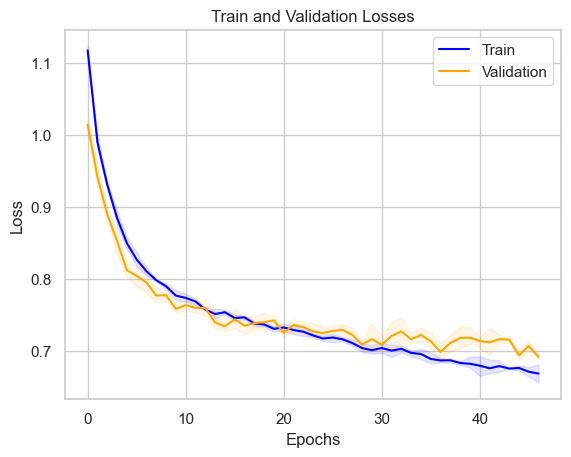

In [ ]:
from helper_methods import plot_avg_losses

plot_avg_losses(t_losses, v_losses)